In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [2]:
def parse_xml(xml_file):
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        # Retrieve all class names from <object> tags
        for obj in root.findall('object'):
            class_name = obj.find('name').text
            if class_name:
                return class_name
        print(f"No class name found in XML: {xml_file}")
        return None
    except Exception as e:
        print(f"Error parsing XML {xml_file}: {e}")
        return None

def load_data(image_dir, xml_dir, class_names):
    images = []
    labels = []
    for class_name in class_names:
        class_folder = os.path.join(image_dir, class_name)
        xml_folder = os.path.join(xml_dir, class_name)
        for img_file in os.listdir(class_folder):
            if img_file.endswith(".jpg"):
                img_path = os.path.join(class_folder, img_file)
                xml_file = os.path.join(xml_folder, img_file.replace(".jpg", ".xml",))
                class_label = parse_xml(xml_file)
                
                # Skip if no valid class label is found
                if class_label is None:
                    print(f"Skipping {img_file} due to missing class label.")
                    continue
                
                # Ensure the class label exists in class_names
                if class_label in class_names:
                    images.append(img_path)
                    labels.append(class_names.index(class_label))
                else:
                    print(f"Warning: {class_label} is not a valid class.")
    return images, labels


No class name found in XML: C:/Users/kaush/Downloads/lips/lips/annotation\inflammed\aug_0_9098.xml
Skipping aug_0_9098.jpg due to missing class label.
Number of images: 596
Number of labels: 596


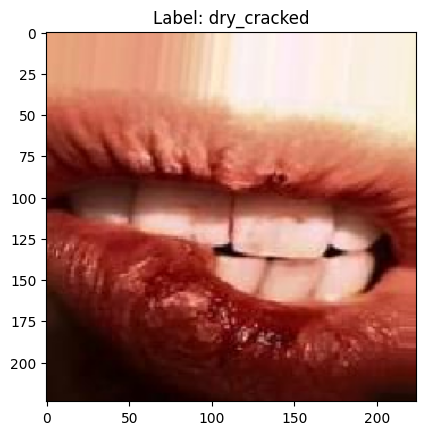

In [3]:
# Preprocess images
def preprocess_images(image_paths, labels, img_size=(224, 224)):
    images = []
    for img_path in image_paths:
        try:
            if not os.path.exists(img_path):
                print(f"Warning: Image path does not exist: {img_path}")
                continue

            img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
            img = tf.keras.preprocessing.image.img_to_array(img)

            if np.all(img == 0):
                print(f"Warning: Image {img_path} is filled with zeros after conversion.")
                continue
            
            images.append(img)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    
    images = np.array(images) / 255.0  # Normalize
    labels = np.array(labels)
    return images, labels

# Define class names
class_names = ["dry_cracked", "inflammed", "pale"]

# Directories for images and annotations
image_dir = "C:/Users/kaush/Downloads/lips/lips/augmented_train"
xml_dir = "C:/Users/kaush/Downloads/lips/lips/annotation"

# Load and preprocess the data
image_paths, labels = load_data(image_dir, xml_dir, class_names)
print(f"Number of images: {len(image_paths)}")
print(f"Number of labels: {len(labels)}")
images, labels = preprocess_images(image_paths, labels)

# Display a sample image
if len(images) > 0:
    plt.imshow(images[0])
    plt.title(f"Label: {class_names[labels[0]]}")
    plt.show()
else:
    print("No images were loaded. Please check the image paths and data.")


Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 61s 4s/step - accuracy: 0.3323 - loss: 1.4955 - val_accuracy: 0.0000e+00 - val_loss: 1.4441
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.5108 - loss: 0.9871 - val_accuracy: 0.0889 - val_loss: 1.3801
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.5727 - loss: 0.8939 - val_accuracy: 0.2556 - val_loss: 1.3540
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.6406 - loss: 0.8087 - val_accuracy: 0.2778 - val_loss: 1.3914
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.6774 - loss: 0.7910 - val_accuracy: 0.1889 - val_loss: 1.5706
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.6929 - loss: 0.6950 - val_accuracy: 0.4333 - val_loss: 1.2424
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.7884 - loss: 0.6327 - val_accuracy: 0.4222 - val_loss: 1.3374
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.7753 - loss: 0.6168 - val_accuracy: 0.4889 - val_l

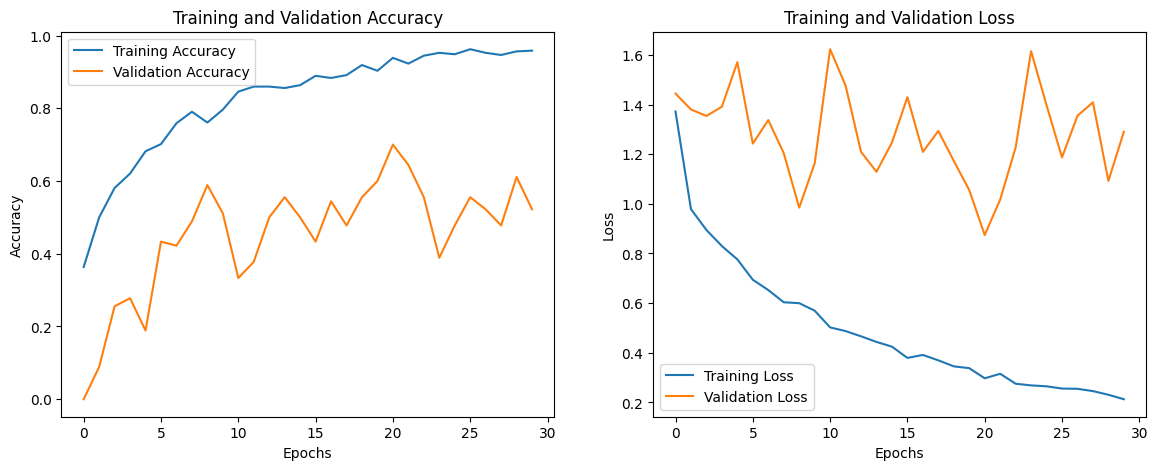

19/19 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step
              precision    recall  f1-score   support

 dry_cracked       0.88      1.00      0.94       198
   inflammed       0.91      0.98      0.94       198
        pale       0.99      0.79      0.87       200

    accuracy                           0.92       596
   macro avg       0.93      0.92      0.92       596
weighted avg       0.93      0.92      0.92       596



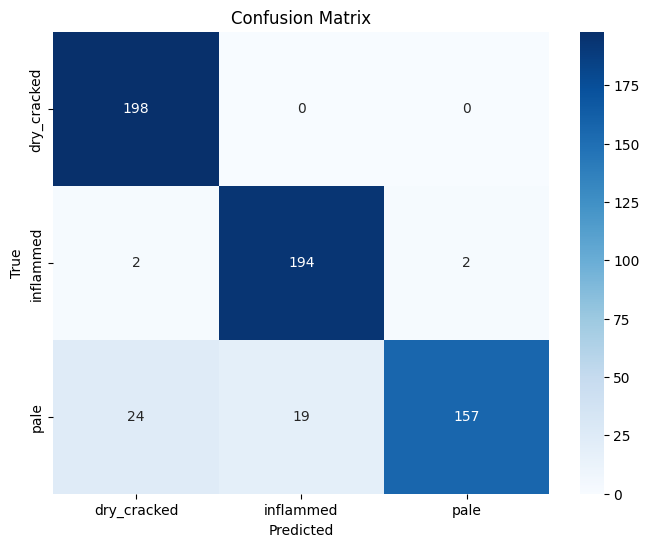

In [4]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Load VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers using Flatten
x = base_model.output
x = Flatten()(x)  # Replace GlobalAveragePooling2D with Flatten
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(class_names), activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(images, labels, epochs=30, validation_split=0.15, batch_size=32)

# Plot accuracy and loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

# Evaluate the model
preds = np.argmax(model.predict(images), axis=1)

# Confusion matrix and classification report
cm = confusion_matrix(labels, preds)
print(classification_report(labels, preds, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Number of test images: 204
Number of test labels: 204


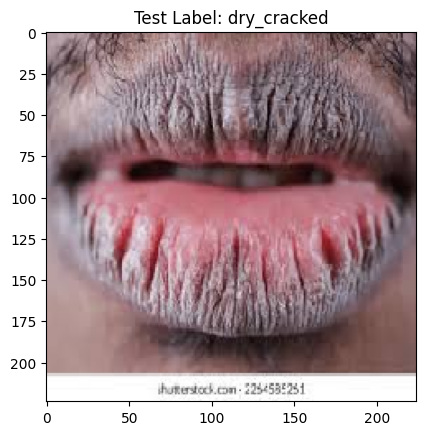

7/7 - 19s - 3s/step - accuracy: 0.7402 - loss: 0.6799
Test Accuracy: 0.74
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step

Classification Report:
              precision    recall  f1-score   support

 dry_cracked       0.71      0.94      0.81        79
   inflammed       0.71      0.69      0.70        72
        pale       0.90      0.51      0.65        53

    accuracy                           0.74       204
   macro avg       0.78      0.71      0.72       204
weighted avg       0.76      0.74      0.73       204



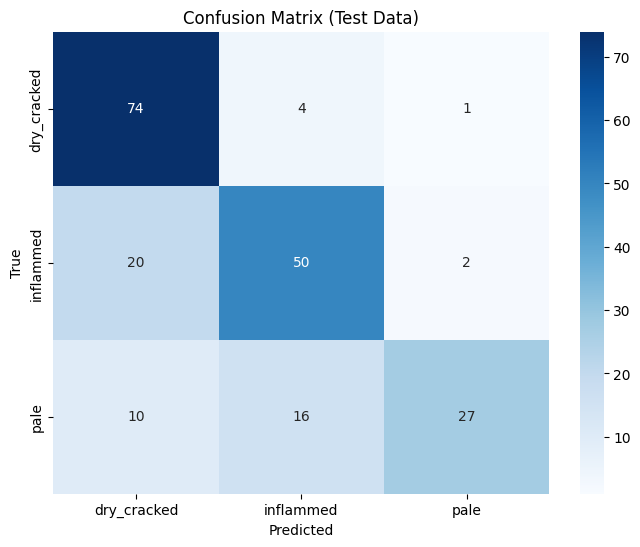

In [5]:
# Path for testing dataset
test_image_dir = "C:/Users/kaush/Downloads/lips/lips/testing"

# Function to preprocess test images
def load_and_preprocess_test_data(image_dir, class_names, img_size=(224, 224)):
    test_images = []
    test_labels = []
    for class_name in class_names:
        class_folder = os.path.join(image_dir, class_name)
        for img_file in os.listdir(class_folder):
            if img_file.endswith(".jpg"):
                img_path = os.path.join(class_folder, img_file)
                try:
                    # Load and preprocess image
                    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
                    img = tf.keras.preprocessing.image.img_to_array(img)
                    img = img / 255.0  # Normalize
                    test_images.append(img)
                    test_labels.append(class_names.index(class_name))
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)
    return test_images, test_labels

# Load and preprocess testing data
test_images, test_labels = load_and_preprocess_test_data(test_image_dir, class_names)

# Debug: Check loaded test data
print(f"Number of test images: {len(test_images)}")
print(f"Number of test labels: {len(test_labels)}")

# Ensure data is loaded correctly
if len(test_images) > 0:
    plt.imshow(test_images[0])
    plt.title(f"Test Label: {class_names[test_labels[0]]}")
    plt.show()
else:
    print("No test images were loaded. Please check the test data path.")

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Predictions on test data
test_preds = np.argmax(model.predict(test_images), axis=1)

# Calculate metrics
print("\nClassification Report:")
report = classification_report(test_labels, test_preds, target_names=class_names)
print(report)

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Data)")
plt.show()


In [1]:
# Save the model to a file
model.save("anovgg19_best_model.h5")


NameError: name 'model' is not defined